In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


train_df = pd.read_csv('OPV_dataset_training.csv')
test_df = pd.read_csv('OPV_dataset_test.csv')

print(train_df.describe())
train_df.drop_duplicates(inplace=True)
train_df.dropna(inplace=True)

#outlier
numerical_columns = ['PCE', 'Voc (V)', 'Jsc (mA cm^2)', 'FF', 'Mw (kg mol^-1)', 
                     'Mn (kg mol^-1)', 'PDI (=Mw/Mn)', 'Monomer (g mol^-1)', 
                     '-HOMO (eV)', '-LUMO (eV)', 'bandgap(eV)']

def remove_outliers(df, columns):
    # For each column in the list
    for column in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter the dataframe to remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Apply the function to remove outliers
train_df= remove_outliers(train_df, numerical_columns)

train_df.info()



            ID No.         PCE     Voc (V)  Jsc (mA cm^2)          FF  \
count   970.000000  968.000000  968.000000     970.000000  969.000000   
mean    603.386598    4.218182    0.783928      29.852990    0.552314   
std     349.078022    2.357199    0.134000     453.440267    0.110518   
min       1.000000    0.010000    0.220000       0.120000    0.250000   
25%     303.250000    2.340000    0.700000       6.305000    0.480000   
50%     601.500000    4.100000    0.800000       9.500000    0.570000   
75%     903.750000    6.000000    0.880000      12.092500    0.640000   
max    1203.000000   10.500000    1.090000   10000.000000    0.759000   

       Mw (kg mol^-1)  Mn (kg mol^-1)  PDI (=Mw/Mn)  Monomer (g mol^-1)  \
count      969.000000      969.000000    969.000000          970.000000   
mean        89.795562       33.620124      2.426791         1120.675258   
std        146.700610       38.650049      1.617168          323.453062   
min          3.900000        1.200000     

In [13]:
# For Voc
X_voc = train_df[['Voc (V)']]
y = train_df['PCE']
model_voc = LinearRegression().fit(X_voc, y)
r2_voc = model_voc.score(X_voc, y)

# For Jsc
X_jsc = train_df[['Jsc (mA cm^2)']]
model_jsc = LinearRegression().fit(X_jsc, y)
r2_jsc = model_jsc.score(X_jsc, y)

# For FF
X_ff = train_df[['FF']]
model_ff = LinearRegression().fit(X_ff, y)
r2_ff = model_ff.score(X_ff, y)

print(f'R² for Voc: {r2_voc}')
print(f'R² for Jsc: {r2_jsc}')
print(f'R² for FF: {r2_ff}')
print("Jsc exhibits strongest correlation with PCE and Voc exhibits weakest correlation with PCE")

R² for Voc: 0.10009398482182619
R² for Jsc: 0.8372202907524335
R² for FF: 0.5824963758855123
Jsc exhibits strongest correlation with PCE and Voc exhibits weakest correlation with PCE


In [14]:
molecular_features = ['Mw (kg mol^-1)', 'Mn (kg mol^-1)', 'PDI (=Mw/Mn)', 'Monomer (g mol^-1)', '-HOMO (eV)', '-LUMO (eV)', 'bandgap(eV)']
X_train = train_df[molecular_features]
X_test = test_df[molecular_features]

# Target variables
y_voc_train = train_df['Voc (V)']
y_jsc_train = train_df['Jsc (mA cm^2)']
y_ff_train = train_df['FF']

y_voc_test = test_df['Voc (V)']
y_jsc_test = test_df['Jsc (mA cm^2)']
y_ff_test = test_df['FF']

# Define a function to perform Lasso regression with cross-validation
def perform_lasso_cv(X_train, y_train):
    lasso = Lasso(random_state=42)
    params = {'alpha': np.logspace(-4, 1, 50)}  # Search space for regularization parameter alpha
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(lasso, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best alpha value
    best_alpha = grid_search.best_params_['alpha']
    best_lasso = grid_search.best_estimator_
    
    return best_lasso, best_alpha
    
# Fit Lasso model for VOC
best_lasso_voc, best_alpha_voc = perform_lasso_cv(X_train, y_voc_train)

# Fit Lasso model for JSC
best_lasso_jsc, best_alpha_jsc = perform_lasso_cv(X_train, y_jsc_train)

# Fit Lasso model for FF
best_lasso_ff, best_alpha_ff = perform_lasso_cv(X_train, y_ff_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Evaluate VOC model
rmse_voc, r2_voc = evaluate_model(best_lasso_voc, X_test, y_voc_test)

# Evaluate JSC model
rmse_jsc, r2_jsc = evaluate_model(best_lasso_jsc, X_test, y_jsc_test)

# Evaluate FF model
rmse_ff, r2_ff = evaluate_model(best_lasso_ff, X_test, y_ff_test)

print(f'VOC - RMSE: {rmse_voc}, R²: {r2_voc}')
print(f'JSC - RMSE: {rmse_jsc}, R²: {r2_jsc}')
print(f'FF - RMSE: {rmse_ff}, R²: {r2_ff}')

def print_important_features(lasso_model, features):
    important_features = np.abs(lasso_model.coef_) > 0
    strongest_feature = None
    max_coef = 0
    
    print("Important features with their coefficients:")
    for feature, coef in zip(features, lasso_model.coef_):
        if coef != 0:
            print(f'{feature}: {coef}')
            # Determine the strongest feature
            if abs(coef) > max_coef:
                max_coef = abs(coef)
                strongest_feature = feature

    if strongest_feature is not None:
        print(f"\nThe molecular parameter that corresponds most strongly with the device parameter is: {strongest_feature} (Coefficient: {lasso_model.coef_[features.index(strongest_feature)]})")

print("Important features for VOC:")
print_important_features(best_lasso_voc, molecular_features)

print("\nImportant features for JSC:")
print_important_features(best_lasso_jsc, molecular_features)

print("\nImportant features for FF:")
print_important_features(best_lasso_ff, molecular_features)



VOC - RMSE: 0.11594231398901074, R²: 0.29802460428195887
JSC - RMSE: 4.220577396427419, R²: -0.04853756547142285
FF - RMSE: 0.12169552535851856, R²: -0.1454503884486975
Important features for VOC:
Important features with their coefficients:
Mw (kg mol^-1): -0.0009561626345224645
Mn (kg mol^-1): 0.002717435642950788
PDI (=Mw/Mn): 0.031495842501085204
Monomer (g mol^-1): 4.209180474533014e-05
-HOMO (eV): 0.23306829780957786
bandgap(eV): 0.23503258818670233

The molecular parameter that corresponds most strongly with the device parameter is: bandgap(eV) (Coefficient: 0.23503258818670233)

Important features for JSC:
Important features with their coefficients:
Mw (kg mol^-1): -0.03480663803313167
Mn (kg mol^-1): 0.15993592947888857
PDI (=Mw/Mn): 1.0194787222097013
Monomer (g mol^-1): 0.0007781764320098979
-HOMO (eV): -1.1569705003764468
-LUMO (eV): -1.1479862269418848
bandgap(eV): -3.9516106240792834

The molecular parameter that corresponds most strongly with the device parameter is: band

In [18]:
# Function to create Bag-of-Elements vector using RDKit
def bag_of_elements(smiles_list):
    bag_of_elements_vectors = []
    all_elements = set()  # Set to keep track of all elements found

    # First pass: Extract all elements from SMILES strings
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue  # Skip invalid SMILES
        elements_in_molecule = [atom.GetSymbol() for atom in mol.GetAtoms()]
        all_elements.update(elements_in_molecule)

    # Convert set to sorted list for consistent ordering
    all_elements = sorted(list(all_elements))

    # Second pass: Create Bag-of-Elements vectors
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bag_vector = np.zeros(len(all_elements))
        if mol is None:
            # If the molecule is None, append a zero vector
            bag_of_elements_vectors.append(bag_vector)
            continue  # Skip further processing for this SMILES

        elements_in_molecule = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        for element in elements_in_molecule:
            if element in all_elements:  # Check if the element is in the list
                element_idx = all_elements.index(element)
                bag_vector[element_idx] += 1
        
        bag_of_elements_vectors.append(bag_vector)

    return np.array(bag_of_elements_vectors), all_elements

# Assuming your SMILES and VOC data are in train_df
smiles_list = train_df['SMILES'].tolist()
voc_values = train_df['Voc (V)'].values  # Assuming VOC values are in a column named 'Voc (V)'

# Create Bag-of-Elements vectors
bag_vectors, search_elements = bag_of_elements(smiles_list)

# Create a new DataFrame for the Bag-of-Elements vectors
bag_of_elements_df = pd.DataFrame(bag_vectors, columns=[f'Element_{element}' for element in search_elements])

# Combine Bag-of-Elements DataFrame with VOC values
combined_df = pd.concat([bag_of_elements_df, pd.Series(voc_values, name='Voc (V)')], axis=1)

# Calculate correlations between elements and VOC
correlations = combined_df.corr()['Voc (V)'].drop('Voc (V)')

# Identify the elements with the highest positive and negative correlation
max_positive_corr = correlations.idxmax(), correlations.max()
max_negative_corr = correlations.idxmin(), correlations.min()

print(f"Element with highest positive correlation to VOC: {max_positive_corr[0]} with correlation {max_positive_corr[1]}")
print(f"Element with highest negative correlation to VOC: {max_negative_corr[0]} with correlation {max_negative_corr[1]}")


Element with highest positive correlation to VOC: Element_F with correlation 0.16082099064626568
Element with highest negative correlation to VOC: Element_Se with correlation -0.09536947932190813


Explained variance by PC1 and PC2: [0.09930489 0.07535324]


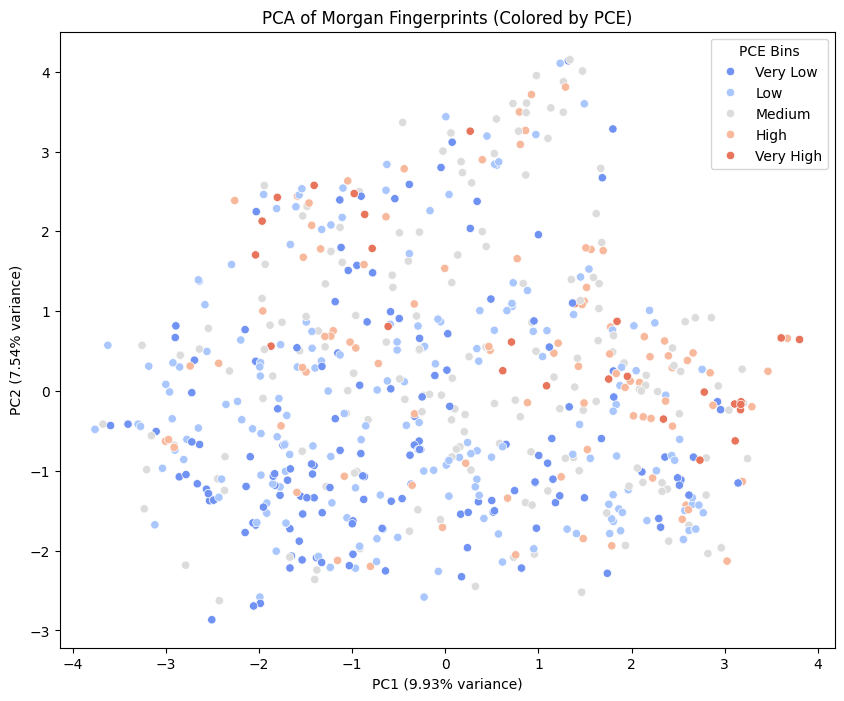

According to the graph, both high and low PCE polymers are not clustering, which stands for a few similarity in between


In [19]:
# Assuming train_df exists with 'SMILES' and 'PCE' columns
smiles_list = train_df['SMILES'].dropna().tolist()
RDLogger.DisableLog("rdApp.*")
# Generate Morgan Fingerprints (1024 bits, radius = 2)
def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=1024):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(np.array(fp))
        else:
            fingerprints.append(np.zeros(n_bits))  # in case of invalid SMILES, return zero vector
    return np.array(fingerprints)

# Generate fingerprints for the training set
fingerprints = generate_morgan_fingerprints(smiles_list)

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fingerprints)

# Explained variance by the two components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1 and PC2: {explained_variance}")

# Add PCA components to the DataFrame
train_df['PC1'] = pca_result[:, 0]
train_df['PC2'] = pca_result[:, 1]

# Bin PCE into categories for coloring
pce_bins = pd.cut(train_df['PCE'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Plot PCA components with PCE bins as color
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue=pce_bins, palette='coolwarm', data=train_df)
plt.title('PCA of Morgan Fingerprints (Colored by PCE)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.legend(title='PCE Bins')
plt.show()

print("According to the graph, both high and low PCE polymers are not clustering, which stands for a few similarity in between")

In [25]:
# Generate Morgan Fingerprints (1024 bits, radius = 2)
fingerprints = generate_morgan_fingerprints(smiles_list)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(fingerprints, train_df['PCE'], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Lasso model with alpha=0.001
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE and R² on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse}")
print(f"Test R²: {r2}")
print("""
    the model in part c is better. The RMSE is significantly smaller, 10 times compare to the simple training model.
    """)

Test RMSE: 1.9173833350209841
Test R²: 0.22111080187749999

    the model in part c is better. The RMSE is significantly smaller, 10 times compare to the simple training model.
    
